# Homework 3

Instruction:

- There are 4 problems worth 5 points each.
- Do not clear output when you submit your homework.
- Submit a single `.ipynb` file.
- Make sure everything runs.
- Make sure the output of the last cell for `time_nonvectorized/time_vectorized` exists.
- Nonvectorized time should be at least 2 times  slower than vectorized time.
- Do not `import` anything other than `numpy`, `time` and `matplotlib.pyplot`
- For full credit, do NOT use in your solution the following
  - `for` loops
  - `while` loops
  - list comprehension, i.e., `[.... for ... in ...]`
  - dictionary comprehension, i.e., `{.... for ... in ...}`
  - `map`
  - recursion

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Background

In "standard" binary classification, we have data
$$
x^{(1)}, \dots, x^{(n)} \in \mathbb{R}^d
$$
where each sample is a *single* $d$-dimensional vector (and the labels $y^{(1)},\dots, y^{(n)} \in \{ \pm 1\}$).



In this homework problem, you will consider a setting where each data point is itself a *collection* of $C$ vectors (for concreteness, take $C = 32$), i.e.,
$$
x^{(i)}
=
\{x^{(i,1)}, \dots, x^{(i,C)}  \}  \quad \mbox{where} \quad x^{(i,c)} \in \mathbb{R}^d \quad \mbox{for each} \quad c =1,\dots, C
$$

Alternatively, you can also view each $x^{(i)}$ as a matrix whose $c$-th column is $x^{(i,c)}$, i.e.,

$$
X^{(i)}
=
\begin{bmatrix}
x^{(i,1)} & \cdots &
x^{(i,C)}
\end{bmatrix} \in \mathbb{R}^{d \times C} \quad \mbox{ is a } d \times C \mbox{ matrix}
$$
(and the labels $y^{(1)},\dots, y^{(n)} \in \{ \pm 1\}$, as before).

In the code, we will name
- $C$ as `n_context`
- $d$ as `n_features`
- $n$ as `n_samples`

In [59]:
n_context = 32
n_features = 3
n_samples = 100

## Load data


In [60]:
X = np.loadtxt("X.csv", delimiter=",").reshape((n_samples, n_context, n_features))
y = np.loadtxt("y.csv", delimiter=",")

## The model

Let $q$ be a positive integer smaller than $d$.
You will consider a model of this form:

Let

$$
\theta = [ W^{(1)}, W^{(2)}, w^{(3)}]
$$

where

$$
W^{(1)} \mbox{ and }  W^{(2)} \in \mathbb{R}^{q \times d}
$$

$$
 w^{(3)} \in \mathbb{R}^{d}
$$

and

$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( X^{(i)\top} W^{(2)\top } W^{(1)} x^{(i,C)})
$$


In the code, we will name
- $q$ as `n_reduced`


In [61]:
n_reduced = 2

### A single forward pass

Now, let us consider the "forward" function on a single data point

In [62]:
i = 13
Xi, yi = X[i], y[i]

In [63]:
np.random.seed(101)
theta = {'w3':  np.random.randn(n_features),
         'W2': np.random.randn(n_features, n_reduced),
         'W1': np.random.randn(n_features, n_reduced)}
W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']

Let's compute it piece by piece, starting with
$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( X^{(i)\top} W^{(2)\top }
 \underbrace{W^{(1)} x^{(i,C)}}_{\mbox{this part}})
$$
which we'll call it `query`

In [64]:
query = Xi[-1] @ W1

next
$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( \underbrace{ X^{(i)\top} W^{(2)\top } }_{\mbox{this part}}
 {W^{(1)} x^{(i,C)}})
$$
which we'll call it `Key`

In [65]:
Key = Xi @ W2

Now,
$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\underbrace{
\mathrm{softmax} (  X^{(i)\top} W^{(2)\top }
 {W^{(1)} x^{(i,C)}})
 }_{\mbox{this part}}
$$


In [66]:
expKq = np.exp(Key@query)
softmaxKq = expKq / np.sum(expKq)

Finally, the whole thing:

In [67]:
softmaxKq @ Xi @ w3

-1.4416064380452254

### (Non-vectorized) forward function

In [68]:
def forward_nonvectorized(Xi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    return softmaxKq @ Xi @ w3

forward_nonvectorized(Xi, theta)

-1.4416064380452254

### Evaluating the (nonvectorized) forward function


We could run the forward function list-wise

In [69]:
np.array([forward_nonvectorized(Xi, theta) for Xi in X][:5])

array([-0.60563255, -0.58440139,  0.3203104 , -0.39511221,  0.89575943])

But it is more efficient if we can run the forward function in "vectorized-mode".

## Loss function

We will use the binary logistic loss

$$
J_i(\theta) := \log(1 + \exp(-y^{(i)} f(X^{(i)} ; \theta)))
$$

So the overall loss/risk is

$$
J(\theta) = \frac{1}{\mathtt{n\_samples} } \sum_{i=1}^{\mathtt{n\_samples}} J_i(\theta)
$$

# [5pts] Problem 1: Vectorize the forward function.


In [70]:
def forward(X, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = X[:, -1, :] @ W1  
    Key = X @ W2  
    expKq = np.exp(np.einsum('ijk,ik->ij', Key, query))  
    softmaxKq = expKq / np.sum(expKq, axis=1, keepdims=True)  
    result = np.einsum('ij,ijk,k->i', softmaxKq, X, w3)  
    return result

forward(X,theta)[:5]

array([-0.60563255, -0.58440139,  0.3203104 , -0.39511221,  0.89575943])

# [5pts] Problem 2: Vectorizing `dJdw3`

First, we compute $ \frac{\partial J}{\partial w^{(3)}}(\theta)$. We won't actually work out the math, but the (non-vectorized, i.e., computing $\frac{\partial J_i}{\partial w^{(3)}}(\theta)$ one $i$ at a time then take the mean) code is as follows.

In [71]:
def compute_dJidw3_nonvectorized(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    zi = softmaxKq @ Xi @ w3
    return (softmaxKq @ Xi) * (-np.exp(-yi*zi))/(1+np.exp(-yi*zi)) * yi


def compute_dJdw3_nonvectorized(X,y,theta):
    return np.array([compute_dJidw3_nonvectorized(X[i], y[i],theta) for i in range(n_samples)]).mean(axis=0)
compute_dJdw3_nonvectorized(X,y,theta)


array([ 0.12614065, -0.10058033, -0.27192813])

In [72]:
def compute_dJdw3(X, y, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = X[:, -1, :] @ W1
    Key = X @ W2
    expKq = np.exp(np.einsum('ijk,ik->ij', Key, query))
    softmaxKq = expKq / np.sum(expKq, axis=1, keepdims=True)
    zi = np.einsum('ij,ijk,k->i', softmaxKq, X, w3)
    gradient = np.einsum('ij,ijk->ik', softmaxKq, X) * (-np.exp(-y * zi) / (1 + np.exp(-y * zi)))[:, np.newaxis] * y[:, np.newaxis]
    return gradient.mean(axis=0)

compute_dJdw3(X,y,theta)

array([ 0.12614065, -0.10058033, -0.27192813])

# [5pts] Problem 3: Vectorizing `dJdW2`

Next, we compute $ \frac{\partial J}{\partial W^{(2)}}(\theta)$. We won't actually work out the math, but the (non-vectorized) code is as follows.

In [73]:
dJdW2 = np.zeros(W2.shape)


def compute_dJidW2_nonvectorized(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    delSoftmax =  np.diag(softmaxKq)-np.outer(softmaxKq,softmaxKq)

    zi = softmaxKq @ Xi @ w3
    loss_der = (-np.exp(-yi*zi))/(1+np.exp(-yi*zi)) * yi
    return np.outer((Xi.T@delSoftmax) @ (Xi@w3), W1.T@Xi[-1])*loss_der

def compute_dJdW2_nonvectorized(X,y,theta):
    dJdW2 = np.zeros(W2.shape)
    for i in range(n_samples):
        dJdW2 += compute_dJidW2_nonvectorized(X[i], y[i],theta)
    return dJdW2/n_samples
compute_dJdW2_nonvectorized(X,y,theta)

array([[0.16829444, 0.20709899],
       [0.10940378, 0.11681514],
       [0.02592543, 0.0226713 ]])

In [74]:
def compute_dJdW2(X, y, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']

    # Calculate query for all samples
    query = X[:, -1] @ W1  # Shape: (100, 2)

    # Calculate Key for all samples
    Key = X @ W2  # Shape: (100, 32, 2)

    # Calculate Key @ query for all samples
    Kq = np.einsum('ijk,ik->ij', Key, query)  # Shape: (100, 32)

    # Calculate softmax
    expKq = np.exp(Kq)
    softmaxKq = expKq / np.sum(expKq, axis=1, keepdims=True)  # Shape: (100, 32)

    # Calculate z for all samples
    z = np.einsum('ij,ijk,k->i', softmaxKq, X, w3)  # Shape: (100,)

    # Calculate the loss derivative
    loss_der = (-np.exp(-y * z)) / (1 + np.exp(-y * z)) * y  # Shape: (100,)

    # Calculate delSoftmax for all samples
    delSoftmax = np.eye(32)[None, :, :] * softmaxKq[:, :, None] - softmaxKq[:, :, None] * softmaxKq[:, None, :]

    # Calculate the term (Xi.T @ delSoftmax) @ (Xi @ w3)
    term1 = np.einsum('ijk,ikl,il->ij', X.transpose(0, 2, 1), delSoftmax, X @ w3)  # Shape: (100, 3)

    # Calculate the final result
    result = np.einsum('ij,ik,i->jk', term1, X[:, -1] @ W1, loss_der)

    return result / X.shape[0]

# Test the function
compute_dJdW2(X, y, theta)

array([[0.16829444, 0.20709899],
       [0.10940378, 0.11681514],
       [0.02592543, 0.0226713 ]])

# [5pts] Problem 4: Vectorizing `dJdW1`

Finally, we compute $ \frac{\partial J}{\partial W^{(1)}}(\theta)$. We won't actually work out the math, but the (non-vectorized) code is as follows.

In [75]:



def compute_dJidW1_nonvectorized(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    delSoftmax =  np.diag(softmaxKq)-np.outer(softmaxKq,softmaxKq)

    zi = softmaxKq @ Xi @ w3
    loss_der = (-np.exp(-yi*zi))/(1+np.exp(-yi*zi)) * yi
    return np.outer(((Xi@W2).T@delSoftmax) @ (Xi@w3), Xi[-1]).T*loss_der


def compute_dJdW1_nonvectorized(X,y,theta):
    dJdW1 = np.zeros(W2.shape)
    for i in range(n_samples):
        dJdW1 += compute_dJidW1_nonvectorized(X[i], y[i],theta)
    return dJdW1/n_samples

compute_dJdW1_nonvectorized(X,y,theta)

array([[-0.02485981,  0.03648229],
       [-0.01022258,  0.05216037],
       [-0.10271108,  0.04190961]])

In [76]:
def compute_dJdW1(Xi, yi, theta):

    # YOUR CODE HERE
    # ...
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    n_samples, n_timesteps, n_features = X.shape

    # Compute query and Key for all samples
    query = X[:, -1] @ W1  # Shape: (n_samples, 2)
    Key = X @ W2  # Shape: (n_samples, n_timesteps, 2)

    # Compute softmax
    attention = np.einsum('ijk,ik->ij', Key, query)  # Shape: (n_samples, n_timesteps)
    expKq = np.exp(attention)
    softmaxKq = expKq / np.sum(expKq, axis=1, keepdims=True)  # Shape: (n_samples, n_timesteps)

    # Compute z
    z = np.einsum('ij,ijk,k->i', softmaxKq, X, w3)  # Shape: (n_samples,)

    # Compute loss derivative
    loss_der = (-np.exp(-y*z) / (1 + np.exp(-y*z))) * y  # Shape: (n_samples,)

    # Compute delSoftmax
    delSoftmax = np.eye(n_timesteps)[None, :, :] * softmaxKq[:, :, None] - \
                 softmaxKq[:, :, None] * softmaxKq[:, None, :]  # Shape: (n_samples, n_timesteps, n_timesteps)

    # Compute term1: (X @ W2).T @ delSoftmax @ (X @ w3)
    term1 = np.einsum('ijk,ikl,il->ij', Key.transpose(0, 2, 1), delSoftmax, X @ w3)  # Shape: (n_samples, 2)

    # Compute term2: X[:, -1]
    term2 = X[:, -1, :]  # Shape: (n_samples, n_features)

    # Compute the final result
    result = np.einsum('ij,ik,i->jk', term2, term1, loss_der)  # Shape: (n_features, 2)

    # Normalize
    dJdW1 = result / n_samples

    return dJdW1

compute_dJdW1(X,y,theta)

array([[-0.02485981,  0.03648229],
       [-0.01022258,  0.05216037],
       [-0.10271108,  0.04190961]])

# (Not graded) Time comparison



In [77]:
np.random.seed(100)
theta = {'w3':  np.random.randn(n_features),
         'W2': np.random.randn(n_features, n_reduced),
         'W1': np.random.randn(n_features, n_reduced)}

error_list = []

start_timer = time.time()
for i in range(1000):
    dJdw3 = compute_dJdw3(X,y,theta)
    dJdW2 = compute_dJdW2(X,y,theta)
    dJdW1 = compute_dJdW1(X,y,theta)

    theta['w3'] -= 0.1*dJdw3
    theta['W2'] -= 0.1*dJdW2
    theta['W1'] -= 0.1*dJdW1
    error = np.mean(np.sign(forward(X,theta))*y<=0.0)
    error_list.append(error)
stop_timer = time.time()
time_vectorized = stop_timer-start_timer
print(f"Time taken: {stop_timer-start_timer}")

Time taken: 1.432042121887207


Text(0, 0.5, 'error (misclassification)')

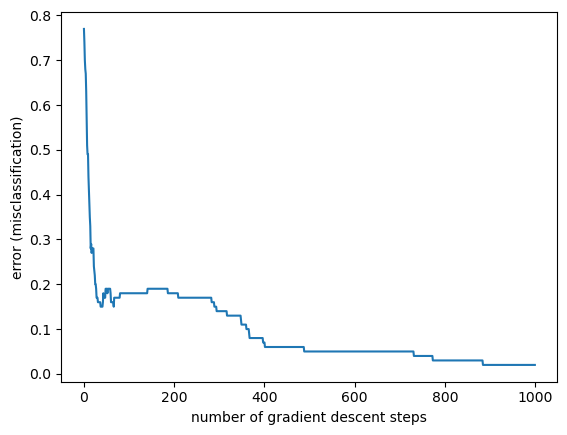

In [78]:

plt.plot(error_list)
plt.xlabel('number of gradient descent steps')
plt.ylabel('error (misclassification)')

In [79]:
np.random.seed(100)
theta = {'w3':  np.random.randn(n_features),
         'W2': np.random.randn(n_features, n_reduced),
         'W1': np.random.randn(n_features, n_reduced)}

error_list = []

start_timer = time.time()
for i in range(1000):
    dJdw3 = compute_dJdw3_nonvectorized(X,y,theta)
    dJdW2 = compute_dJdW2_nonvectorized(X,y,theta)
    dJdW1 = compute_dJdW1_nonvectorized(X,y,theta)

    theta['w3'] -= 0.1*dJdw3
    theta['W2'] -= 0.1*dJdW2
    theta['W1'] -= 0.1*dJdW1
    error = np.mean(np.sign(forward(X,theta))*y<=0.0)
    error_list.append(error)
stop_timer = time.time()
time_nonvectorized = stop_timer-start_timer
print(f"Time taken: {stop_timer-start_timer}")

Time taken: 4.3513031005859375


Text(0, 0.5, 'error (misclassification)')

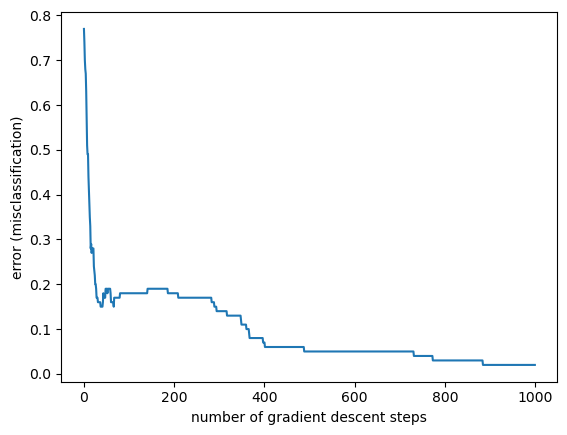

In [80]:

plt.plot(error_list)
plt.xlabel('number of gradient descent steps')
plt.ylabel('error (misclassification)')

In [81]:
time_nonvectorized/time_vectorized

3.038530106119785